In [5]:
import librosa
import soundfile
import os, glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score







In [6]:
# ---------------------------
# Feature extraction function
# ---------------------------

def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))
    return result

In [7]:

# ---------------------------
# Emotion mapping
# ---------------------------
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']


In [8]:
# ---------------------------
# Load dataset
# ---------------------------
def load_data(test_size=0.25):
    x, y = [], []
    for file in glob.glob("Data/Actor_*/*.wav"):  # <- put your RAVDESS path here
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [13]:
# Split into train/test sets
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

# ---------------------------
# Train MLP Classifier
# ---------------------------
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08,
                      hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Train Successful')


Train Successful


In [14]:

# ---------------------------
# Evaluate
# ---------------------------
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("MLP Classifier Accuracy: {:.2f}%".format(accuracy * 100))


MLP Classifier Accuracy: 65.10%


In [2]:
import sys
!{sys.executable} -m pip install matplotlib seaborn


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------ --------------------------- 2.6/8.1 MB 12.5 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 12.8 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.3 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.3 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 8.6 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7

Accuracy: 65.10%
Precision: 70.98%
Recall: 65.10%
F1 Score: 65.76%

Classification Report:

              precision    recall  f1-score   support

        calm       0.97      0.61      0.75        57
       happy       0.66      0.56      0.61        48
     fearful       0.65      0.59      0.62        37
     disgust       0.51      0.82      0.63        50

    accuracy                           0.65       192
   macro avg       0.70      0.65      0.65       192
weighted avg       0.71      0.65      0.66       192



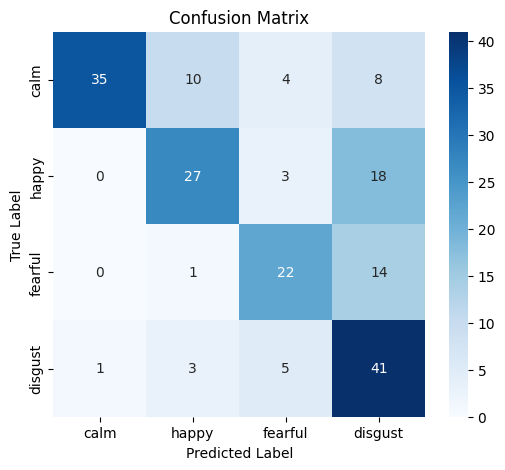

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Precision, Recall, F1
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['calm','happy','fearful','disgust']))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['calm','happy','fearful','disgust'],
            yticklabels=['calm','happy','fearful','disgust'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
